In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
IMAGE_SIZE = 256
EPOCHS = 500
BATCH = 32
LR = 1e-3 

PATH = "/kaggle/input/segmentation-d/data_set/"

In [4]:
import random

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    # Shuffle the images
    combined = list(zip(images, masks))
    random.shuffle(combined)
    images, masks = zip(*combined)

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [6]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=16):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [7]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  20286
Validation data:  2535
Testing data:  2535


In [8]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

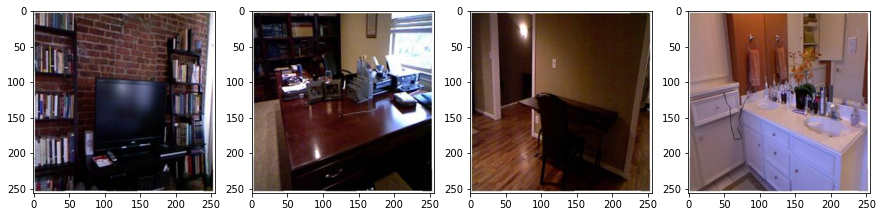

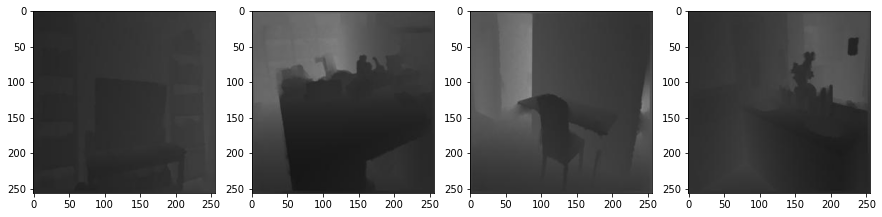

In [9]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [10]:
def conv_block(inputs, filters, kernel_size, activation, dropout_rate):
#   R = tf.keras.layers.Conv2D(filters, 1, padding='same')(inputs)
  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  if activation == 'LeakyReLU':
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
  elif activation == 'sigmoid':
    x = tf.keras.layers.Activation('sigmoid')(x)
#   

#   x = tf.keras.layers.Add()([R, x])

  x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  if activation == 'LeakyReLU':
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(dropout_rate)(x)
  elif activation == 'sigmoid':
    x = tf.keras.layers.Activation('sigmoid')(x)
#   x = tf.keras.layers.Dropout(dropout_rate)(x)
  return x

def down_block(inputs, filters, kernel_size, activation,dropout_rate):
  x = conv_block(inputs, filters, kernel_size, activation,dropout_rate)
  x_pool = tf.keras.layers.MaxPooling2D()(x)
  return x, x_pool

def up_block(inputs, skip_input, filters, kernel_size, activation,dropout_rate):
  x = tf.keras.layers.UpSampling2D()(inputs)
  x = tf.keras.layers.Concatenate()([x, skip_input])
  x = conv_block(x, filters, kernel_size, activation,dropout_rate)
  return x

def UNetModel(input_shape=(256, 256, 3)):
  inputs = tf.keras.Input(shape=input_shape, name="input_image")
  # Define the encoder layers
  conv1, pool1 = down_block(inputs, 16, 7, 'LeakyReLU',dropout_rate=0.5)
  conv2, pool2 = down_block(pool1, 32, 3, 'LeakyReLU',dropout_rate=0.5)
  conv3, pool3 = down_block(pool2, 64, 1, 'LeakyReLU',dropout_rate=0.5)
  conv4, pool4 = down_block(pool3, 128, 3, 'LeakyReLU',dropout_rate=0.5)
  conv5, pool5 = down_block(pool4, 256, 7, 'LeakyReLU',dropout_rate=0.5)
  conv6, pool6 = down_block(pool5, 512, 3, 'LeakyReLU',dropout_rate=0.5)

  conv7 = conv_block(pool6, 1024, 3, 'LeakyReLU',dropout_rate=0.5)

  # Define the decoder layers
  up1 = up_block(conv7, conv6, 256, 7, 'LeakyReLU',dropout_rate=0.5)
  up2 = up_block(up1, conv5, 128, 3, 'LeakyReLU',dropout_rate=0.5)
  up3 = up_block(up2, conv4, 64, 1, 'LeakyReLU',dropout_rate=0.5)
  up4 = up_block(up3, conv3, 32, 3, 'LeakyReLU',dropout_rate=0.5)
  up5 = up_block(up4, conv2, 16, 7, 'LeakyReLU',dropout_rate=0.5)
  up6 = up_block(up5, conv1,8, 1, 'LeakyReLU',dropout_rate=0.5)
  
  # Define the output layer
#   out = conv_block(up6, 1, 1, 'sigmoid',dropout_rate=0.5)
  out = conv_block(up6, 1, 1, 'sigmoid',dropout_rate=0.5)

  # Create the model and return it
  model = tf.keras.Model(inputs=inputs, outputs=out)
  return model

In [11]:
model = UNetModel()
model.summary()

2023-01-04 17:17:10.195989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:17:10.197209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:17:10.370423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:17:10.371339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-04 17:17:10.372197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 2368        input_image[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [13]:
def IoU_loss(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return 1 - (intersection + 1) / (union + 1)

In [14]:
def RMSE_loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true, y_pred)

In [15]:
def combined_loss(y_true, y_pred):
    combined_loss = dice_loss(y_true, y_pred) + RMSE_loss(y_true, y_pred) + IoU_loss(y_true, y_pred)
    return combined_loss

In [16]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [17]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [RMSE_loss,dice_loss,IoU_loss,Recall(), Precision(),'accuracy']
model.compile(loss=combined_loss, optimizer=opt, metrics=metrics)

In [18]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [19]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

2023-01-04 17:17:15.260798: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2023-01-04 17:17:30.886674: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


634/634 [==============================] - 439s 648ms/step - loss: 2.5935 - RMSE_loss: 0.0803 - dice_loss: 0.5990 - IoU_loss: 0.7491 - recall: 0.4709 - precision: 1.0000 - accuracy: 5.4186e-05 - val_loss: 1.5431 - val_RMSE_loss: 0.0812 - val_dice_loss: 0.6198 - val_IoU_loss: 0.7652 - val_recall: 0.9558 - val_precision: 1.0000 - val_accuracy: 5.6238e-05
Epoch 2/500
634/634 [==============================] - 329s 518ms/step - loss: 1.6347 - RMSE_loss: 0.0810 - dice_loss: 0.6004 - IoU_loss: 0.7501 - recall: 0.4625 - precision: 1.0000 - accuracy: 5.3305e-05 - val_loss: 1.5754 - val_RMSE_loss: 0.1013 - val_dice_loss: 0.6123 - val_IoU_loss: 0.7594 - val_recall: 0.9907 - val_precision: 1.0000 - val_accuracy: 5.6268e-05
Epoch 3/500
634/634 [==============================] - 328s 518ms/step - loss: 1.5908 - RMSE_loss: 0.0787 - dice_loss: 0.5958 - IoU_loss: 0.7466 - recall: 0.4302 - precision: 1.0000 - accuracy: 5.4160e-05 - val_loss: 1.5205 - val_RMSE_loss: 0.0492 - val_dice_loss: 0.6422 - val_

In [20]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1
    
model.evaluate(test_dataset, steps=test_steps)

80/80 [==============================] - 101s 1s/step - loss: 1.2922 - RMSE_loss: 0.0500 - dice_loss: 0.5372 - IoU_loss: 0.6985 - recall: 0.3709 - precision: 1.0000 - accuracy: 6.5086e-05


[1.2921603918075562,
 0.049956005066633224,
 0.537218451499939,
 0.6985240578651428,
 0.37087827920913696,
 1.0,
 6.508611113531515e-05]

In [21]:
model.save('Hubaib_HK_Model.h5')
model.save_weights('Hubaib_HK_.h5')

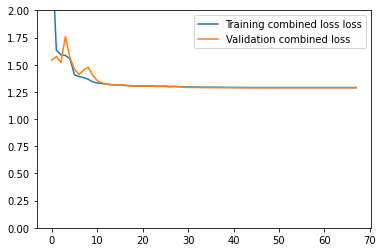

In [22]:
plt.plot(history.history['loss'], label='Training combined loss loss')
plt.plot(history.history['val_loss'], label='Validation combined loss')
ax = plt.gca()  # Get the current Axes object
ax.set_ylim([0, 2])  # Set the y-axis limits
plt.legend()
plt.show()

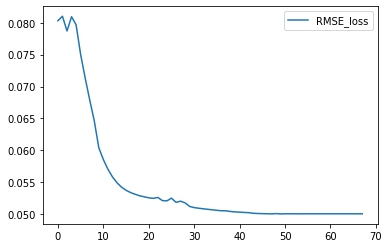

In [23]:
plt.plot(history.history['RMSE_loss'], label='RMSE_loss')
plt.legend()
plt.show()

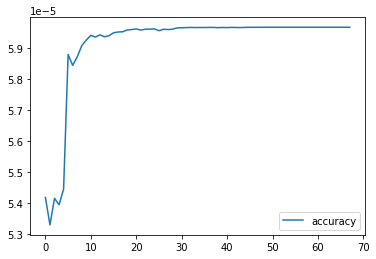

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

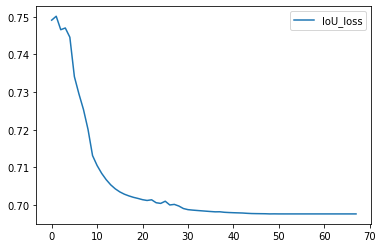

In [25]:
plt.plot(history.history['IoU_loss'], label='IoU_loss')
plt.legend()
plt.show()

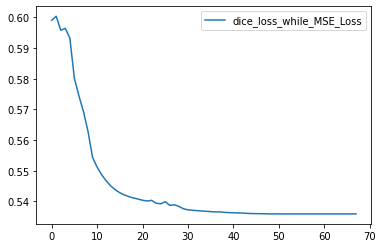

In [26]:
plt.plot(history.history['dice_loss'], label='dice_loss_while_MSE_Loss')
plt.legend()
plt.show()

In [27]:
# model.save('FF.h5')
# model.save_weights('FF_W.h5')

In [28]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [29]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

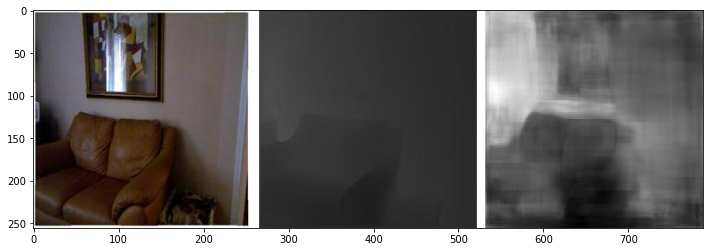

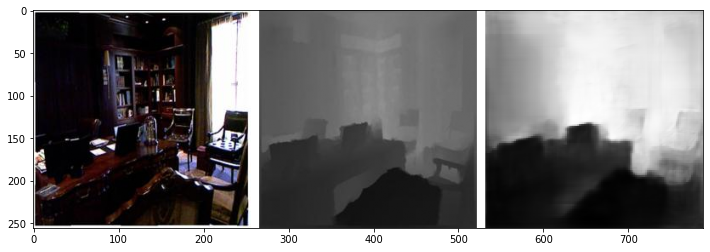

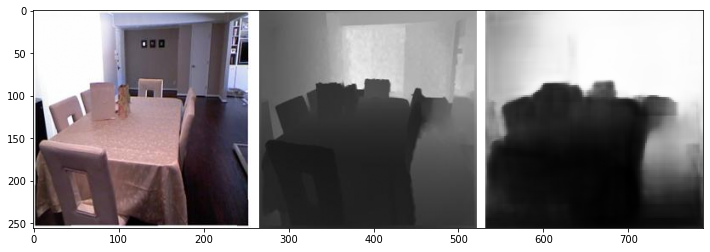

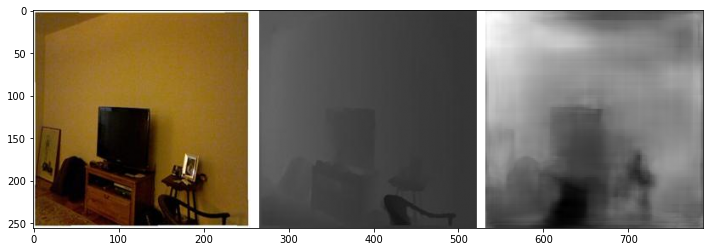

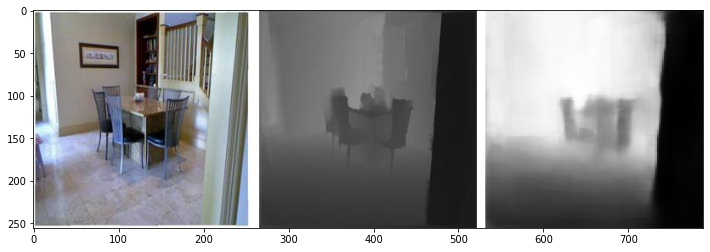

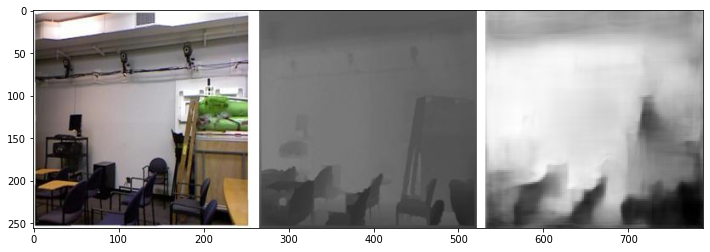

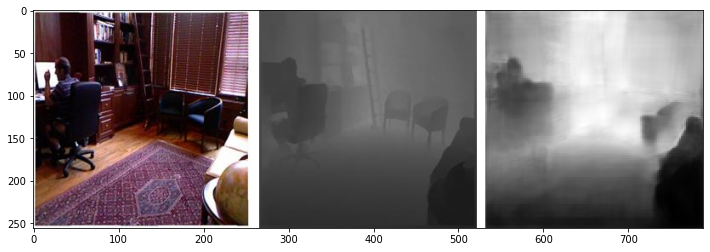

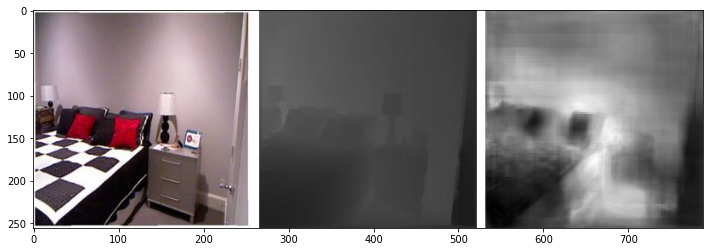

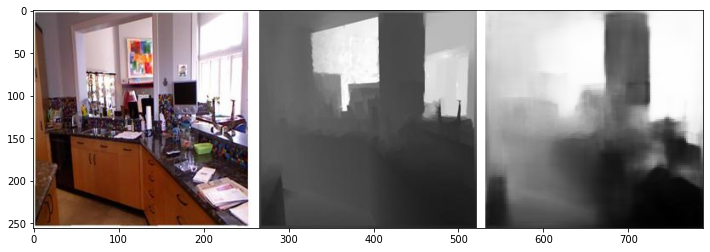

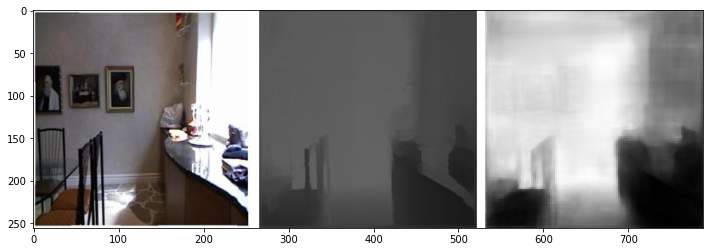

In [30]:
for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_grayscale = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred_grayscale)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)